In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numba
import scipy.stats

import warnings
warnings.filterwarnings('ignore')

from typing import Dict

from saturation.simulation import *
from saturation.distributions import *
from saturation.geometry import *
from saturation.plotting import *

In [2]:
def percentile(n):
    @numba.jit(forceobj=True, fastmath=True)
    def _percentile(x):
        return np.percentile(x, n)
    return _percentile

def aggregate_simulations(stats: pd.DataFrame, expected_count: int):
    columns_to_aggregate = [
        'n_craters_in_study_region',
        'areal_density',
        'z',
        'za'
    ]
    aggregations = {
        x: [
            'min',
            pd.NamedAgg(column=x, aggfunc=percentile(25)),
            'mean',
            pd.NamedAgg(column=x, aggfunc=percentile(75)),
            'max'
        ]
        for x in columns_to_aggregate
    }
    col_names = [
        [
            f'{x}_min',
            f'{x}_25_percentile',
            f'{x}_mean',
            f'{x}_75_percentile',
            f'{x}_max'
        ]
        for x in columns_to_aggregate
    ]
    col_names = [y for x in col_names for y in x]

    grouped = stats.groupby(['n_craters_added_in_study_region']).agg(
        aggregations
    )

    grouped.columns = col_names
    grouped['group_count'] = stats.groupby(['n_craters_added_in_study_region']).n_craters_in_study_region.agg('count')
    
    # Make sure all samples have full data
    grouped = grouped[grouped.group_count == expected_count]
    grouped.reset_index(inplace=True)
    
    return grouped


def plot_statistics(stats: pd.DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    # Plot crater count
    ax = axes[0][0]
    ax.plot(stats.n_craters_added_in_study_region, stats.n_craters_in_study_region_min, label='Min')
    ax.plot(stats.n_craters_added_in_study_region, stats.n_craters_in_study_region_25_percentile, label='25th')
    ax.plot(stats.n_craters_added_in_study_region, stats.n_craters_in_study_region_mean, label='Mean')
    ax.plot(stats.n_craters_added_in_study_region, stats.n_craters_in_study_region_75_percentile, label='75th')
    ax.plot(stats.n_craters_added_in_study_region, stats.n_craters_in_study_region_max, label='Max')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Craters in Study Region')
    ax.legend(loc='upper left')

    # Plot crater count
    ax = axes[0][1]
    ax.plot(stats.n_craters_added_in_study_region, stats.areal_density_min, label='Min')
    ax.plot(stats.n_craters_added_in_study_region, stats.areal_density_25_percentile, label='25th')
    ax.plot(stats.n_craters_added_in_study_region, stats.areal_density_mean, label='Mean')
    ax.plot(stats.n_craters_added_in_study_region, stats.areal_density_75_percentile, label='75th')
    ax.plot(stats.n_craters_added_in_study_region, stats.areal_density_max, label='Max')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Areal Density')

    # Plot Z statistic
    ax = axes[1][0]
    ax.plot(stats.n_craters_added_in_study_region, stats.z_min, label='Min')
    ax.plot(stats.n_craters_added_in_study_region, stats.z_25_percentile, label='25th')
    ax.plot(stats.n_craters_added_in_study_region, stats.z_mean, label='Mean')
    ax.plot(stats.n_craters_added_in_study_region, stats.z_75_percentile, label='75th')
    ax.plot(stats.n_craters_added_in_study_region, stats.z_max, label='Max')
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Z Statistic')

    # Plot Za statistic
    ax = axes[1][1]
    ax.plot(stats.n_craters_added_in_study_region, stats.za_min, label='Min')
    ax.plot(stats.n_craters_added_in_study_region, stats.za_25_percentile, label='25th')
    ax.plot(stats.n_craters_added_in_study_region, stats.za_mean, label='Mean')
    ax.plot(stats.n_craters_added_in_study_region, stats.za_75_percentile, label='75th')
    ax.plot(stats.n_craters_added_in_study_region, stats.za_max, label='Max')
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Za Statistic')

    plt.show()

def plot_four_metric_plots(python_stats: pd.DataFrame,
                           idl_stats: pd.DataFrame,
                           n_craters_column: str,
                           areal_density_column: str,
                           z_column: str,
                           za_column: str,
                           output_filename: str):
    fig, axes = plt.subplot_mosaic([['(a)', '(b)'], ['(c)', '(d)']],
                               figsize=(12, 7),
                               constrained_layout=True)

    for label, ax in axes.items():
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize='large',
                verticalalignment='top',
                fontfamily='serif',
                bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))

    # Plot crater count
    ax = axes['(a)']
    ax.plot(python_stats.n_craters_added_in_study_region, python_stats[n_craters_column], color='b', label='Python')
    ax.plot(idl_stats.n_craters_added_in_study_region, idl_stats[n_craters_column], color='r', label='IDL')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Craters in Study Region')
    ax.legend(loc='lower right')

    # Plot crater count
    ax = axes['(b)']
    ax.plot(python_stats.n_craters_added_in_study_region, python_stats[areal_density_column], color='b', label='Python')
    ax.plot(idl_stats.n_craters_added_in_study_region, idl_stats[areal_density_column], color='r', label='IDL')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Areal Density')

    # Plot Z statistic
    ax = axes['(c)']
    ax.plot(python_stats.n_craters_added_in_study_region, python_stats[z_column], color='b', label='Python')
    ax.plot(idl_stats.n_craters_added_in_study_region, idl_stats[z_column], color='r', label='IDL')
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Z Statistic')

    # Plot Za statistic
    ax = axes['(d)']
    ax.plot(python_stats.n_craters_added_in_study_region, python_stats[za_column], color='b', label='Python')
    ax.plot(idl_stats.n_craters_added_in_study_region, idl_stats[za_column], color='r', label='IDL')
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Za Statistic')

    plt.savefig(output_filename)
    plt.show()

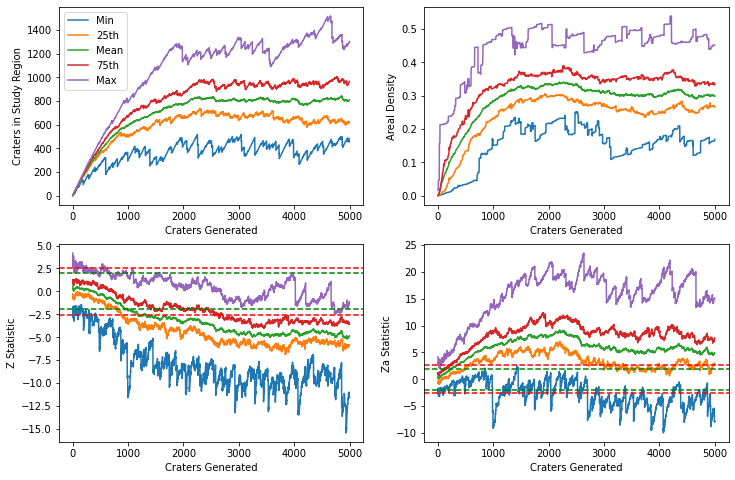

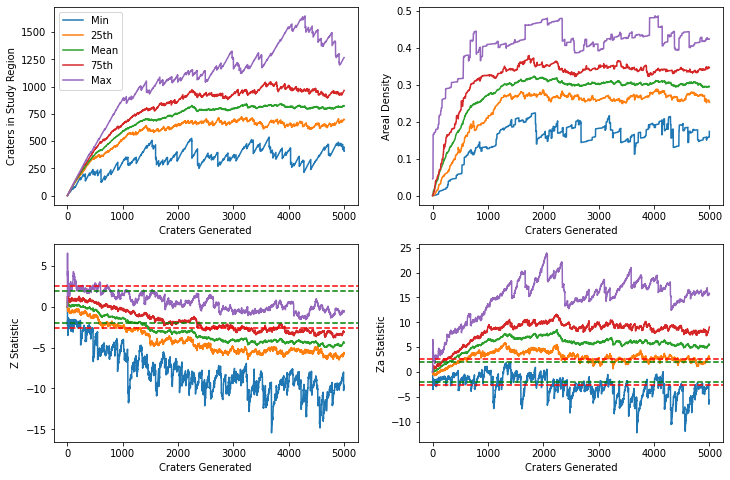

In [3]:
python_base_path = '/home/mason/full_runs/python'
idl_base_path = '/home/mason/full_runs/idl'
slope = 1.00
r_stat_multiplier = 3.00
min_rim_percentage = 0.40
effective_radius_multiplier = 1.50

filenames = [
    f'{python_base_path}/{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}/{x}/statistics.csv'
    for x in range(1, 56)
]

python_sim_stats = []
for index, filename in enumerate(filenames):
    data = pd.read_csv(filename)
    data['simulation_id'] = index
    if 'n_craters_added_in_observed_area' in data.columns:
        data = data.rename(columns={
            'n_craters_added_in_observed_area': 'n_craters_added_in_study_region',
            'n_craters_in_observed_area': 'n_craters_in_study_region'})
    python_sim_stats.append(data)

python_stats_combined = pd.concat(python_sim_stats, axis=0).dropna()
python_stats_aggregated = aggregate_simulations(python_stats_combined, len(python_sim_stats))


filenames = [
    f'{idl_base_path}/{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}/run_{-slope:.2f}_{effective_radius_multiplier:.2f}_{min_rim_percentage:.2f}_{r_stat_multiplier:.2f}_{x}_1.csv'
    for x in range(1, 56)
]

idl_sim_stats = []
for index, filename in enumerate(filenames):
    data = pd.read_csv(filename, skiprows=1)
    data.columns = ['n_craters_added_in_study_region', 'n_craters_in_study_region', 'areal_density', 'z', 'za']
    data.areal_density = data.areal_density / 10000**2
    data['simulation_id'] = index
    idl_sim_stats.append(data)

idl_stats_combined = pd.concat(idl_sim_stats, axis=0).dropna()
idl_stats_aggregated = aggregate_simulations(idl_stats_combined, len(idl_sim_stats))

plot_statistics(python_stats_aggregated)
plot_statistics(idl_stats_aggregated)

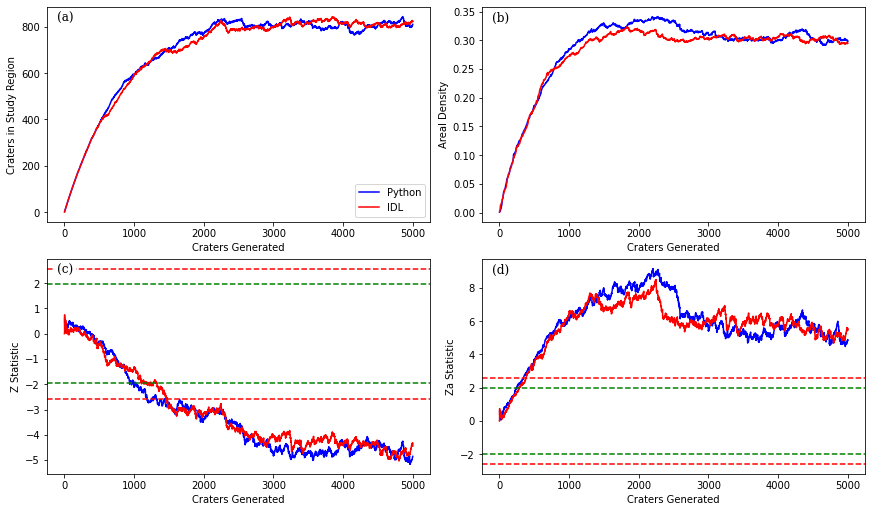

In [4]:
plot_four_metric_plots(python_stats_aggregated,
                       idl_stats_aggregated,
                       'n_craters_in_study_region_mean',
                       'areal_density_mean',
                       'z_mean',
                       'za_mean',
                       f'figures/mean_curves_{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}.png')

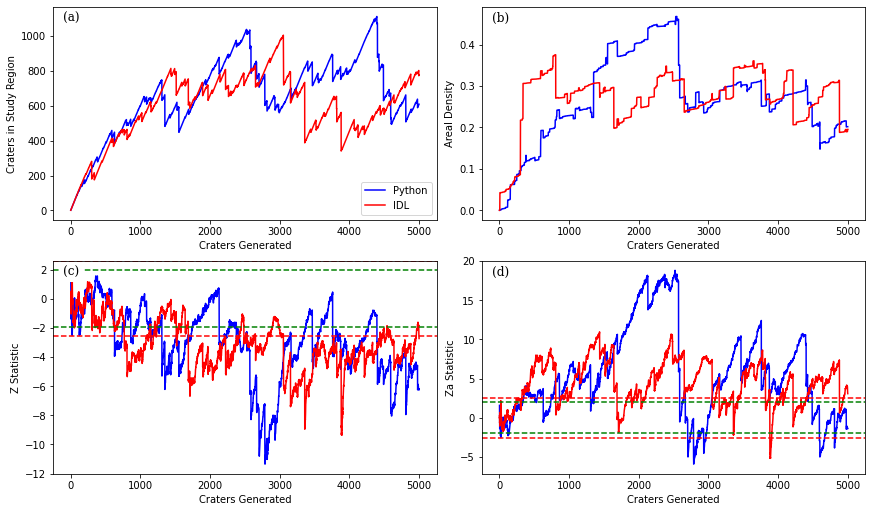

In [5]:
plot_four_metric_plots(python_stats_combined[python_stats_combined.simulation_id == 0],
                       idl_stats_combined[idl_stats_combined.simulation_id == 0],
                       'n_craters_in_study_region',
                       'areal_density',
                       'z',
                       'za',
                       f'figures/single_sim_curves_{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}.png')

### Plotting SFDs

In [6]:
def plot_sfds(state: pd.DataFrame, times: List[int]):
    # Track min and max radii
    min_radius = 1e10
    max_radius = 0
    
    for time in times:
        state_at_time = state[state.n_craters_added_in_observed_area == time]
        radii = state_at_time.radius.sort_values()
        
        min_r = radii.head(1).squeeze()
        max_r = radii.tail(1).squeeze()
        if min_r < min_radius:
            min_radius = min_r
        if max_r > max_radius:
            max_radius = max_r
        
        plt.plot(radii, range(len(radii) + 1, 1, -1), label=time)
        
    # Plot geometric saturation lines
    saturation_range = np.array(range(int(min_radius), int(max_radius)))
    saturation_vals = np.array([10000**2 / (np.pi * x**2) for x in saturation_range])
    plt.plot(saturation_range, saturation_vals/10, 'b--', label="10% Sat")
    plt.plot(saturation_range, saturation_vals/100, 'r--', label="1% Sat")
    
    # Plot production lines
    production_vals = np.array([x**-2.8 for x in saturation_range])
    plt.plot(saturation_range, production_vals * 1e6, 'g--', label="Prod 1e6")
    plt.plot(saturation_range, production_vals * 1e7, 'g--', label="Prod 1e7")
    plt.plot(saturation_range, production_vals * 1e8, 'g--', label="Prod 1e8")
    
    plt.subplots_adjust(right=0.7)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xscale('log')
    plt.yscale('log')

In [7]:
base_path = '/home/mason/full_runs/python/'
slope = 1.00
r_stat_multiplier = 3.00
min_rim_percentage = 0.40
effective_radius_multiplier = 1.50
n_craters = [250, 500, 1000, 2000, 3000, 4000, 4999]

states = []
for n in n_craters:
    state = pd.read_csv(f'{python_base_path}/{slope:.2f}_{r_stat_multiplier:.2f}_{min_rim_percentage:.2f}_{effective_radius_multiplier:.2f}/1/state_{n}.csv')
    states.append(state)

state = pd.concat(states, axis=0)

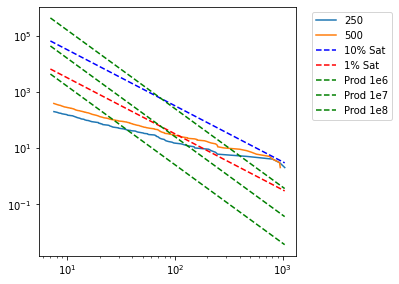

In [8]:
plot_sfds(state, n_craters[0:2])

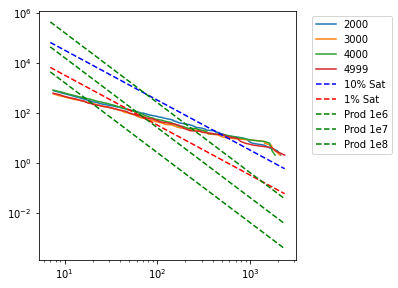

In [9]:
plot_sfds(state, n_craters[3:])